This notebook includes functions for plotting the figures reported in the paper.

In [1]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [2]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [3]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [4]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [5]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [6]:
!pwd

/geode2/home/u015/baotruon/BigRed200/simsom/sm_nov25/all_plots


In [7]:
# Directory containing experiment results
RES_DIR = "/N/project/simsom/simsom_v3/nov25/zl10_11212023/results"

# Directory to save figures
PLOT_DIR = "figures_zl10_11212023"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [8]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [9]:
folders = ["baseline"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.9074580670495893]
values [0.8957474508898637]
values [0.9013971296056715]
values [0.8942393207141119]
values [0.9010564378784462]
Overall quality when there is no bots: 0.9


# Shuffle 
Effects of network structure on Quality

In [10]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.633526,0.656530,0.659163,0.705159,0.658002,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.608620,0.610814,0.578517,0.559561,0.652190,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.687013,0.693626,0.699946,0.656063,0.682696,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.879718,0.861558,0.873252,0.866549,0.827153,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852189,0.852969,0.845289,0.860182,0.842314,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.850602,0.850049,0.869267,0.872847,0.871186,community_shuffle__None2.json,community


In [11]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

In [12]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
54,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.836971,0.846906,0.857077,0.80023,0.846494,None


In [13]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.633526,0.656530,0.659163,0.705159,0.658002,community_shuffle__None3.json,community
1,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.608620,0.610814,0.578517,0.559561,0.652190,hub_shuffle__None3.json,hub
2,1,0.05,0.10,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.687013,0.693626,0.699946,0.656063,0.682696,all_shuffle__None3.json,all
3,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.879718,0.861558,0.873252,0.866549,0.827153,all_shuffle__None2.json,all
4,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852189,0.852969,0.845289,0.860182,0.842314,hub_shuffle__None2.json,hub
5,1,0.05,0.01,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.850602,0.850049,0.869267,0.872847,0.871186,community_shuffle__None2.json,community


In [14]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [15]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.836971,...,0.800230,0.846494,None,NaN,0.929988,0.941028,0.952329,0.889164,0.940570,0
1,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.633526,...,0.705159,0.658002,community,community_shuffle__None3.json,0.703934,0.729494,0.732420,0.783528,0.731130,1
2,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.608620,...,0.559561,0.652190,hub,hub_shuffle__None3.json,0.676260,0.678697,0.642811,0.621748,0.724672,2
3,1,0.05,0.10,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.687013,...,0.656063,0.682696,all,all_shuffle__None3.json,0.763365,0.770713,0.777735,0.728976,0.758568,3
4,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.879718,...,0.866549,0.827153,all,all_shuffle__None2.json,0.977487,0.957308,0.970302,0.962854,0.919080,4
5,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.852189,...,0.860182,0.842314,hub,hub_shuffle__None2.json,0.946898,0.947765,0.939232,0.955780,0.935925,5
6,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.850602,...,0.872847,0.871186,community,community_shuffle__None2.json,0.945135,0.944520,0.965874,0.969852,0.968006,6


In [16]:
results

,id,run_no,quality_3,graph_gml,targeting_criterion,shuffle,phi,gamma,quality_1,rho,file_name,quality_4,quality_0,theta,beta,epsilon,mu,quality_2,relative_quality_
0,0,0,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.929988
1,1,0,0.705159,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.10,0.656530,0.8,community_shuffle__None3.json,0.658002,0.633526,1,0.05,0.0001,0.5,0.659163,0.703934
2,2,0,0.559561,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.10,0.610814,0.8,hub_shuffle__None3.json,0.652190,0.608620,1,0.05,0.0001,0.5,0.578517,0.676260
3,3,0,0.656063,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.10,0.693626,0.8,all_shuffle__None3.json,0.682696,0.687013,1,0.05,0.0001,0.5,0.699946,0.763365
4,4,0,0.866549,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.01,0.861558,0.8,all_shuffle__None2.json,0.827153,0.879718,1,0.05,0.0001,0.5,0.873252,0.977487
5,5,0,0.860182,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.01,0.852969,0.8,hub_shuffle__None2.json,0.842314,0.852189,1,0.05,0.0001,0.5,0.845289,0.946898
6,6,0,0.872847,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.01,0.850049,0.8,community_shuffle__None2.json,0.871186,0.850602,1,0.05,0.0001,0.5,0.869267,0.945135
7,0,1,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.941028
8,1,1,0.705159,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.10,0.656530,0.8,community_shuffle__None3.json,0.658002,0.633526,1,0.05,0.0001,0.5,0.659163,0.729494
9,2,1,0.559561,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.10,0.610814,0.8,hub_shuffle__None3.json,0.652190,0.608620,1,0.05,0.0001,0.5,0.578517,0.678697


Plot data for default values $\gamma=0.01$

In [17]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,quality_3,graph_gml,targeting_criterion,shuffle,phi,gamma,quality_1,rho,file_name,quality_4,quality_0,theta,beta,epsilon,mu,quality_2,relative_quality_
0,0,0,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.929988
4,4,0,0.866549,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.01,0.861558,0.8,all_shuffle__None2.json,0.827153,0.879718,1,0.05,0.0001,0.5,0.873252,0.977487
5,5,0,0.860182,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.01,0.852969,0.8,hub_shuffle__None2.json,0.842314,0.852189,1,0.05,0.0001,0.5,0.845289,0.946898
6,6,0,0.872847,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.01,0.850049,0.8,community_shuffle__None2.json,0.871186,0.850602,1,0.05,0.0001,0.5,0.869267,0.945135
7,0,1,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.941028


In [18]:
# !pip install statannotations

In [19]:
plot_data

,id,run_no,quality_3,graph_gml,targeting_criterion,shuffle,phi,gamma,quality_1,rho,file_name,quality_4,quality_0,theta,beta,epsilon,mu,quality_2,relative_quality_
0,0,0,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.929988
4,4,0,0.866549,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.01,0.861558,0.8,all_shuffle__None2.json,0.827153,0.879718,1,0.05,0.0001,0.5,0.873252,0.977487
5,5,0,0.860182,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.01,0.852969,0.8,hub_shuffle__None2.json,0.842314,0.852189,1,0.05,0.0001,0.5,0.845289,0.946898
6,6,0,0.872847,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.01,0.850049,0.8,community_shuffle__None2.json,0.871186,0.850602,1,0.05,0.0001,0.5,0.869267,0.945135
7,0,1,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.941028
11,4,1,0.866549,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.01,0.861558,0.8,all_shuffle__None2.json,0.827153,0.879718,1,0.05,0.0001,0.5,0.873252,0.957308
12,5,1,0.860182,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,hub,0.0,0.01,0.852969,0.8,hub_shuffle__None2.json,0.842314,0.852189,1,0.05,0.0001,0.5,0.845289,0.947765
13,6,1,0.872847,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,community,0.0,0.01,0.850049,0.8,community_shuffle__None2.json,0.871186,0.850602,1,0.05,0.0001,0.5,0.869267,0.944520
14,0,2,0.800230,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,None,0.0,0.01,0.846906,0.8,NaN,0.846494,0.836971,1,0.05,0.0001,0.5,0.857077,0.952329
18,4,2,0.866549,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,all,0.0,0.01,0.861558,0.8,all_shuffle__None2.json,0.827153,0.879718,1,0.05,0.0001,0.5,0.873252,0.970302


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:6.321e-02 t=2.274e+00
hubs vs. communities: Welch's t-test independent samples, P_val:8.394e-02 t=-2.032e+00
random vs. hubs: Welch's t-test independent samples, P_val:3.055e-01 t=1.143e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:1.110e-01 t=1.793e+00


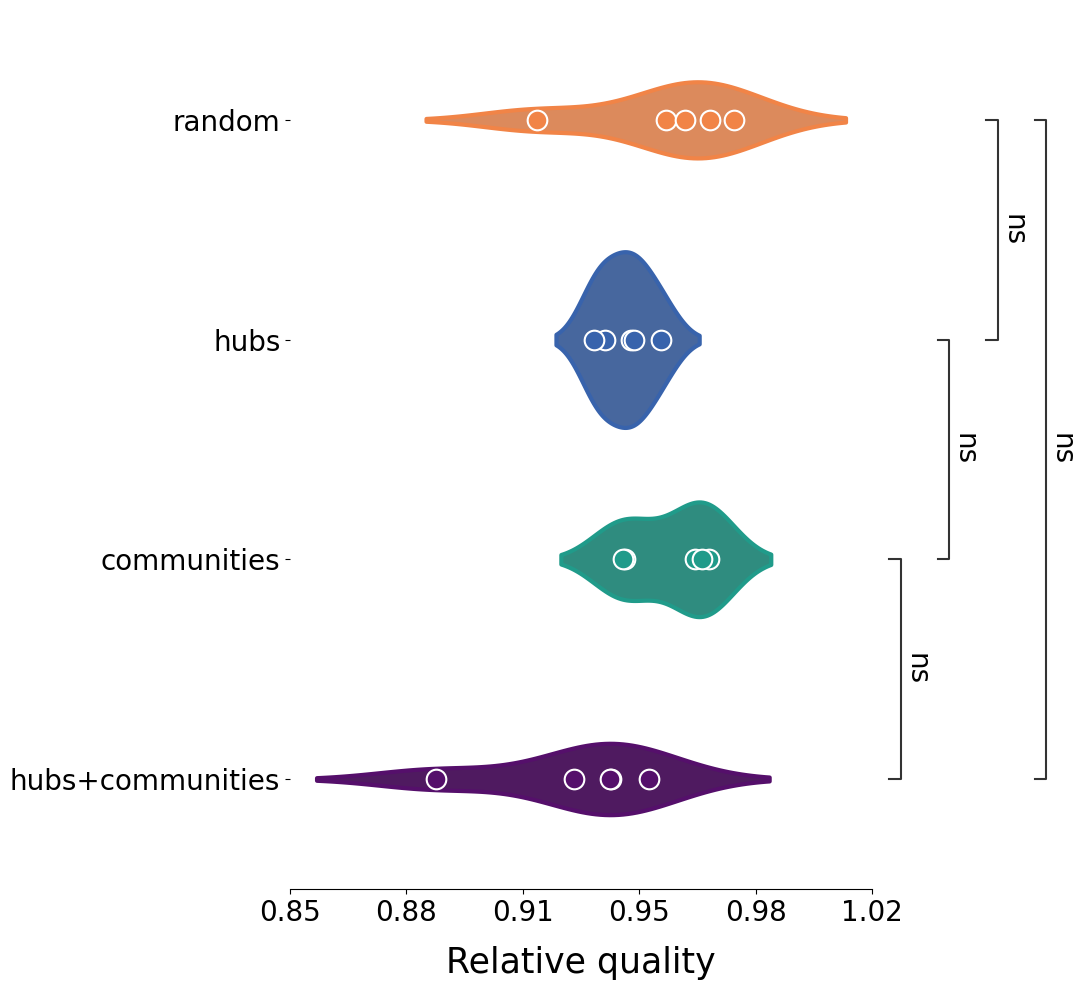

In [20]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [21]:
folders = ["vary_alpha"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

,id,run_no,graph_gml,alpha,targeting_criterion,relative_quality_1,phi,gamma,relative_quality_0,relative_quality_4,rho,relative_quality_3,theta,relative_quality_2,beta,epsilon,mu,quality_
13,5,1,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,none,1.004055,0,0,1.004108,0.998302,0.8,0.989154,1,0.989647,0,0.0001,0.5,0.903629
5,5,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,none,1.004055,0,0,1.004108,0.998302,0.8,0.989154,1,0.989647,0,0.0001,0.5,0.903676
21,5,2,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,none,1.004055,0,0,1.004108,0.998302,0.8,0.989154,1,0.989647,0,0.0001,0.5,0.890662
37,5,4,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,none,1.004055,0,0,1.004108,0.998302,0.8,0.989154,1,0.989647,0,0.0001,0.5,0.898451
29,5,3,/N/project/simsom/simsom_v3/10242023_v3.3/data...,1,none,1.004055,0,0,1.004108,0.998302,0.8,0.989154,1,0.989647,0,0.0001,0.5,0.890218


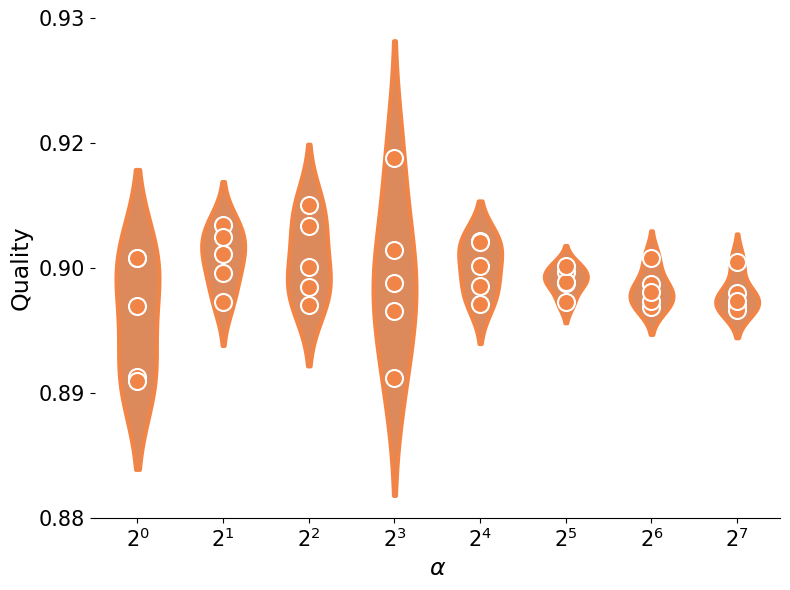

In [22]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [23]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,graph_gml,alpha,targeting_criterion,phi,gamma,rho,theta,beta,epsilon,mu,quality_
3,3,0,/N/project/simsom/simsom_v3/10242023_v3.3/data...,15,none,0,0,0.8,1,0,0.0001,0.1,0.880245
8,3,1,/N/project/simsom/simsom_v3/10242023_v3.3/data...,15,none,0,0,0.8,1,0,0.0001,0.1,0.878818
18,3,3,/N/project/simsom/simsom_v3/10242023_v3.3/data...,15,none,0,0,0.8,1,0,0.0001,0.1,0.900304
23,3,4,/N/project/simsom/simsom_v3/10242023_v3.3/data...,15,none,0,0,0.8,1,0,0.0001,0.1,0.889645
13,3,2,/N/project/simsom/simsom_v3/10242023_v3.3/data...,15,none,0,0,0.8,1,0,0.0001,0.1,0.907656


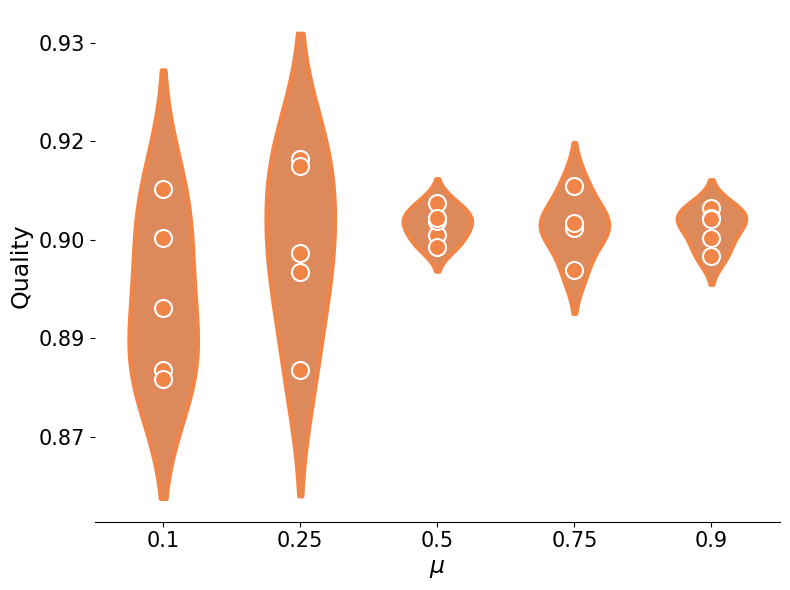

In [24]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [25]:
data = read_data(
    RES_DIR, folders=["vary_thetaphi_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# thetaphi

### Phigamma

In [26]:
data = read_data(
    RES_DIR, folders=["vary_phigamma"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)
# phigamma

### Thetagamma

In [27]:
data = read_data(RES_DIR, folders=["vary_thetagamma_5runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

In [28]:
thetagamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,alpha
0,4,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.898154,0.896510,0.889780,0.894539,0.891365,15
1,8,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.790022,0.812582,0.825674,0.801066,0.793685,15
2,32,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.851835,0.855510,0.879363,0.882914,0.863015,15
3,16,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.461554,0.489599,0.493967,0.492292,0.475894,15
4,16,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.886799,0.886568,0.886812,0.903346,0.889600,15
5,8,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.889248,0.900247,0.902589,0.894589,0.907026,15
6,32,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.896665,0.898997,0.896002,0.891644,0.905883,15
7,64,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.901861,0.898729,0.898208,0.899389,0.899516,15
8,16,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.901428,0.900928,0.911249,0.903621,0.902465,15
9,8,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.869226,0.888906,0.887581,0.893613,0.865713,15


## Single param plots
Subset data (only plot default values for each panel)

In [29]:
# VARYING GAMMA
vary_gamma = thetagamma[thetagamma.theta==1]
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
vary_phi = phigamma[phigamma.gamma == 0.01]
vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
x = vary_phi["phi"]
y = vary_phi["mean_relative_quality"]
err = vary_phi["ci_relative_quality"]
err = vary_phi["std_relative_quality"]
phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = thetaphi[thetaphi.phi == 0]
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [0.9919596830729728, 0.9903880127386657, 1.0019433402920448, 0.9947170665206782, 0.9800362910231697]
values [1.00070211724066, 0.9940713000964381, 1.0042826878051903, 1.0033688778190357, 0.9946152846812845]
values [0.6681830634596171, 0.6477251944243896, 0.6934218745441569, 0.6480596108132465, 0.665898630827375]
values [0.9043826630555162, 0.9080402475582163, 0.9157266024669953, 0.930978031156188, 0.9495983273126621]
values [0.7176660547903462, 0.6878379236541386, 0.6893563873793529, 0.6836757307324919, 0.6903780941965832]
values [0.725234410955257, 0.6786866020803397, 0.6835099766635886, 0.6722581167795875, 0.6814540802795507]
values [0.7312449553249559, 0.7222046266326757, 0.7280304087100432, 0.7107913290273082, 0.6984119368876603]
values [0.6966997614734044, 0.6720087697784216, 0.6767943412338998, 0.6816716867192194, 0.6657941260014799]
values [0.7321191476816622, 0.703434385927557, 0.6870970599797398, 0.7006585969335075, 0.6888033132566113]
values [0.6875763188773562, 0.6843

In [30]:
vary_gamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_4,alpha,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,mean_relative_quality,std_relative_quality,ci_relative_quality
10,1,0.05,0.0010,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.892744,...,0.882013,15,0.991960,0.990388,1.001943,0.994717,0.980036,0.991809,0.007934,0.009851
16,1,0.05,0.0001,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.900612,...,0.895134,15,1.000702,0.994071,1.004283,1.003369,0.994615,0.999408,0.004811,0.005973
22,1,0.05,0.1000,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.601351,...,0.599295,15,0.668183,0.647725,0.693422,0.648060,0.665899,0.664658,0.018732,0.023259
25,1,0.05,0.0100,0.5,0.0001,0,0.8,/N/project/simsom/simsom_v3/10242023_v3.3/data...,none,0.813926,...,0.854619,15,0.904383,0.908040,0.915727,0.930978,0.949598,0.921745,0.018618,0.023118


### Plot

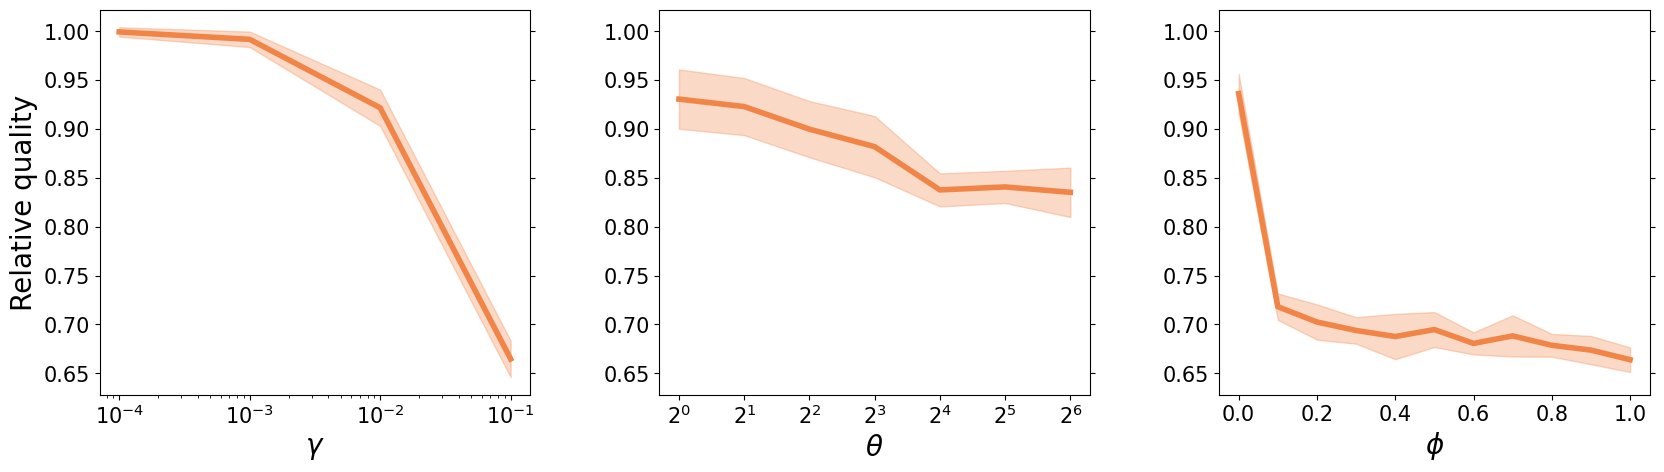

In [31]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
ax = axs[1]
draw_lines(ax, thetadata, color=color)
ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(
    plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
)
# ax.xaxis.set_major_locator(plt.MultipleLocator())

# PHI
ax = axs[2]
draw_lines(ax, phidata, color=color)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

# Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [32]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=['theta','phi'], keep='first')
thetaphi = thetaphi.pivot(index='theta', columns='phi', values='mean_relative_quality').reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ['theta']+PHI
thetaphi.head()

values [0.6623748077457731, 0.6680708544243673, 0.6798698709009037, 0.6556246962566646, 0.6875651027508985]
values [0.6310376007720927, 0.6053126371095121, 0.5887201395574425, 0.5955584421713349, 0.6024162459102048]
values [0.5976299340654023, 0.6223037659174859, 0.5977905049149711, 0.5875710816701661, 0.5926381789411047]
values [0.7112984426795245, 0.6902760032686772, 0.6908983848907257, 0.6923822937862358, 0.7040454955403521]
values [0.6733716794449246, 0.6548319960935272, 0.6855546781562364, 0.6793428743209, 0.6751756262140649]
values [0.6909838109995927, 0.6765300387602227, 0.6860855119351079, 0.7107178635944383, 0.6872379477038377]
values [0.6198376105184648, 0.5973862089611988, 0.612521342072211, 0.6086336546492057, 0.6063185371014151]
values [0.6121115037299957, 0.5998151363043204, 0.620203228264261, 0.5910172601694119, 0.5895830830545037]
values [0.6178493618540306, 0.620272172393, 0.6109239812639834, 0.6050550629237019, 0.67229320309949]
values [0.6366413975563421, 0.655809726

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.930616,0.718995,0.702403,0.693434,0.690313,0.688939,0.673242,0.676483,0.666768,0.684066,0.673084
1,2,0.922984,0.719422,0.694239,0.676004,0.670701,0.659616,0.664970,0.649978,0.664457,0.658497,0.650779
2,4,0.899842,0.697780,0.676790,0.675572,0.659424,0.669214,0.653653,0.635812,0.635938,0.632810,0.634079
3,8,0.881937,0.693504,0.673655,0.661087,0.639982,0.641521,0.632209,0.616914,0.634038,0.627089,0.615562
4,16,0.837666,0.692664,0.661024,0.647878,0.620848,0.635023,0.623318,0.617011,0.625279,0.611602,0.615366


In [33]:
tp_matrix = thetaphi.loc[:,PHI].values
#Check shape:
tp_matrix.shape 

(7, 11)

### Data: Thetagamma matrix

In [34]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=['theta','gamma'], keep='first')
thetagamma = thetagamma.pivot(index='theta', columns='gamma', values='mean_relative_quality').reset_index()
thetagamma.head()

values [0.9979714777801404, 0.9961445305376935, 0.9886666525850492, 0.9939550292979565, 0.9904278505298514]
values [0.8778220361563621, 0.9028892402323987, 0.9174366755099324, 0.890093489047489, 0.8818923633200548]
values [0.9465043332039892, 0.9505883818489588, 0.9770919757308912, 0.9810381736887369, 0.9589272228361893]
values [0.5128497483804557, 0.5440110549981725, 0.5488646499154177, 0.5470037804464621, 0.5287830818711313]
values [0.9853545543608574, 0.9850979014000282, 0.985368669721389, 1.003740528050444, 0.9884671178529792]
values [0.9880757802031659, 1.0002974898324628, 1.0028987660195616, 0.994009716677532, 1.007829944293145]
values [0.996316982249801, 0.998908560058383, 0.9955803317991294, 0.9907380724153014, 1.0065597418706271]
values [1.002090440074028, 0.9986101005565007, 0.9980318184708059, 0.9993432654749423, 0.9994842480522649]
values [1.0016096341779865, 1.0010538529569044, 1.0125220436690294, 1.0040454546172293, 1.0027614379757592]
values [0.9658288671559744, 0.987695

gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.999408,0.991809,0.921745,0.664658
1,2,0.999243,0.991614,0.926402,0.621140
2,4,1.001942,0.993433,0.903533,0.592832
3,8,0.998622,0.978920,0.894027,0.557733
4,16,1.004398,0.989606,0.872395,0.536302


In [35]:
tg_matrix = thetagamma.loc[:,GAMMA].values
tg_matrix.shape

(7, 4)

### Data: Phigamma matrix

In [36]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix = "relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=['phi','gamma'], keep='first')
phigamma = phigamma.pivot(index='phi', columns='gamma', values='mean_relative_quality').reset_index()
phigamma.head()

values [0.7786744681605442, 0.7761918519984663, 0.7824028261579774, 0.801853047756735, 0.7715119381692868]
values [0.7176660547903462, 0.6878379236541386, 0.6893563873793529, 0.6836757307324919, 0.6903780941965832]
values [0.7670414775117635, 0.7505525932913368, 0.7695804711242747, 0.7648051962687022, 0.7286042711931641]
values [0.7907869248461347, 0.8418516423064516, 0.8120967573074231, 0.8533679058226371, 0.821653193331361]
values [0.7573407610292865, 0.751873966947207, 0.7691682512919433, 0.7536004598363748, 0.7562900968550769]
values [0.48931674109118894, 0.49534193374283736, 0.5094701440514492, 0.49823257129455994, 0.5017057424064244]
values [0.7744925765292286, 0.7949997778941666, 0.8021390573133775, 0.7329273635299288, 0.7750239554299769]
values [0.725234410955257, 0.6786866020803397, 0.6835099766635886, 0.6722581167795875, 0.6814540802795507]
values [0.8278225098613663, 0.8444583554885068, 0.9576331508425232, 0.9136593825687234, 0.9213918602395513]
values [0.7801078471284224, 0

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,1.003914,0.989363,0.936285,0.649403
1,0.1,0.930650,0.812622,0.718137,0.556099
2,0.2,0.932057,0.782127,0.702423,0.520455
3,0.3,0.892993,0.785517,0.693783,0.494935
4,0.4,0.894146,0.775917,0.687584,0.498813


In [37]:
pg_matrix = phigamma.loc[:,GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

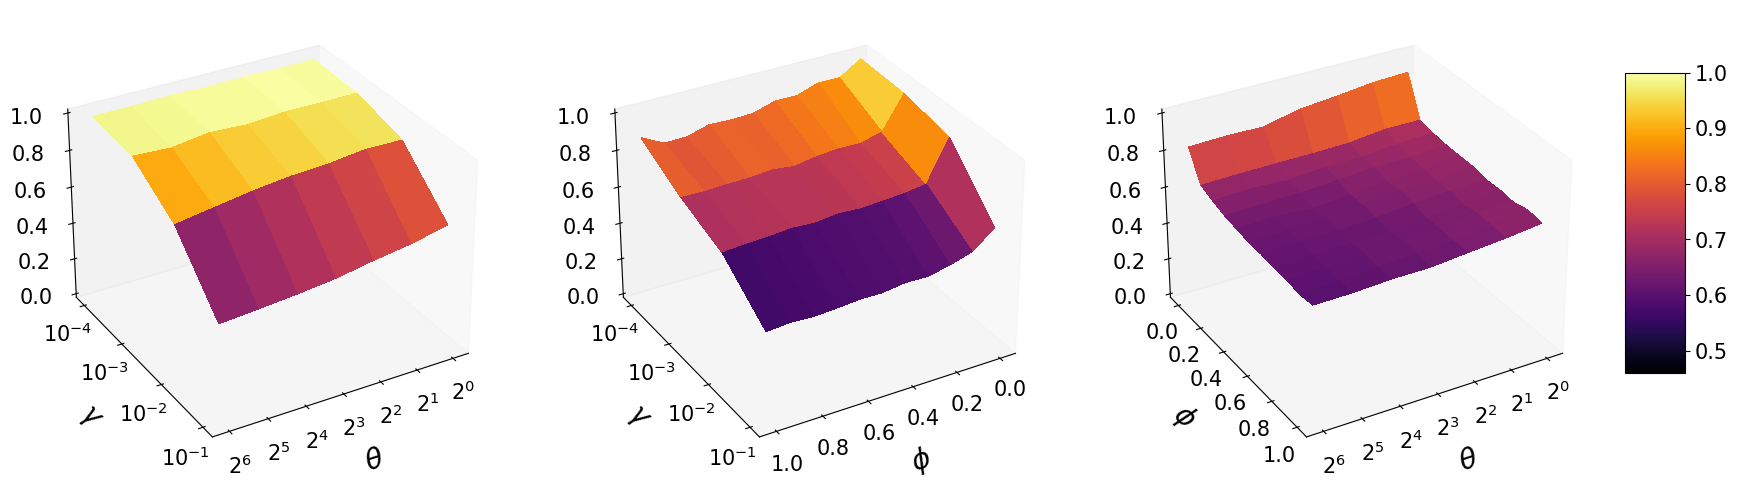

In [38]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet 
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238

def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$" 
  
fpath = os.path.join(PLOT_DIR, "joint")  
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1,3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN=np.round(min_qual,2)
VMAX=np.round(max_qual,2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA              
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax=axs[0]
surf = ax.plot_surface(np.log2(X), np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) #Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


# ## PHIGAMMA              
ax=axs[1]

X=PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX
                          )

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda val,pos: log_tick_formatter(val,base=10)))
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis='y', nbins=len(GAMMA)) # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, .27, .03, .5])# x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, 
             cax=cbar_ax
            )


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax=axs[2]
surf = ax.plot_surface(np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, 
                           vmin=VMIN, vmax=VMAX)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0,1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [39]:
data = read_data(RES_DIR, folders=["strategies_5runs"])
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:4.727e-02 t=-2.434e+00
random vs. misinformation: Welch's t-test independent samples, P_val:2.125e-02 t=-2.875e+00
random vs. liberal: Welch's t-test independent samples, P_val:8.885e-06 t=-1.235e+01
random vs. conservative: Welch's t-test independent samples, P_val:5.582e-05 t=-8.087e+00


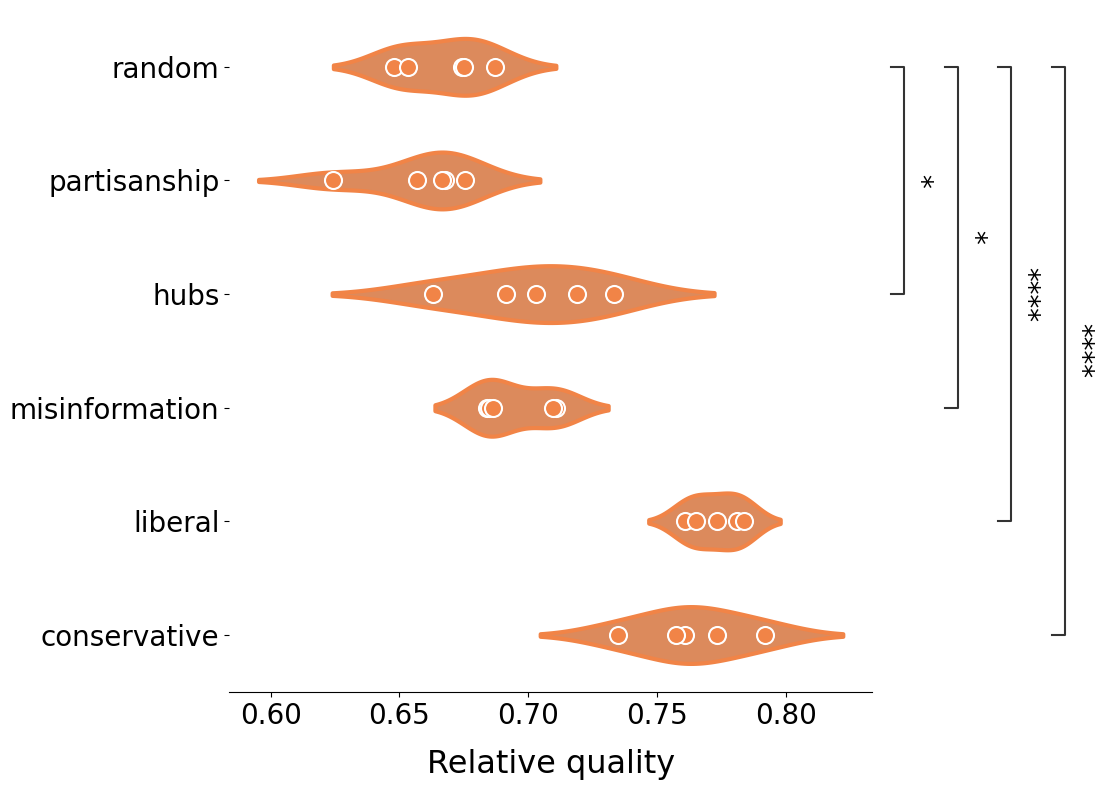

In [40]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()